<a href="https://colab.research.google.com/github/castrokelly/Hackathon-Petrobras/blob/main/Petrobots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados e Detecção de Anomalias com BibMon e 3W Dataset

Este notebook foi desenvolvido pela **Equipe 113 - Petrobots** entre os dias **11 e 13 de outubro de 2024** como parte do desafio do **Hackathon Petrobras**.

## Time 113 Petrobots:
- **Kelly Christine Alvarenga de Castro** - [kelly@decastro.com](mailto:kelly@decastro.com)
- **Luana Serigato Meneghelli** - [meneghelli@alunos.utfpr.edu.br](mailto:meneghelli@alunos.utfpr.edu.br)
- **Gabriel Seleme** - [seleme@alunos.utfpr.edu.br](mailto:seleme@alunos.utfpr.edu.br)

---

### Objetivo
O objetivo deste projeto é **integrar a biblioteca BibMon com o 3W Dataset**, utilizando as ferramentas de monitoramento e detecção de falhas da BibMon para identificar eventos presentes na versão **2.0.0** do **3W Dataset**, recentemente lançada. Esta integração visa aprimorar a capacidade de detecção de anomalias em processos de extração de petróleo, contribuindo para operações mais seguras e eficientes.

### BibMon
Biblioteca dedicada ao monitoramento de processos, detecção de falhas e sensoriamento virtual. Oferece ferramentas robustas para análise e interpretação de dados em ambientes industriais, facilitando a identificação de eventos anômalos e a manutenção preditiva.

- **GitHub BibMon:** [https://github.com/petrobras/bibmon](https://github.com/petrobras/bibmon)

### 3W Dataset
O **3W** fornece um conjunto de dados que registra eventos indesejados em poços de petróleo marítimos. Este dataset é fundamental para o desenvolvimento e teste de algoritmos de detecção de anomalias, permitindo a análise de diferentes tipos de falhas e suas características.

- **GitHub 3W:** [https://github.com/petrobras/3w](https://github.com/petrobras/3w)

---


# **1. Análise Exploratória do Dataset 3W - Versão 2.0**

## **1.1 Introdução**

Neste notebook, o grupo **Petrobots** realiza uma análise exploratória do **dataset 3W** na versão 2.0, seguido pela aplicação de técnicas de inteligência artificial utilizando a biblioteca **BibMon**. O objetivo é detectar eventos indesejados presentes no dataset e avaliar a taxa de detecção de falhas, além da taxa de falsos alarmes.

Na primeira etapa, aplicamos técnicas de **PCA (Principal Component Analysis)** para detecção de falhas. Além disso, realizamos as correções necessárias para compatibilizar o código com a nova versão do dataset, detalhando as modificações entre a versão anterior e a versão atual.

In [ ]:
!pip install bibmon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [168]:
import bibmon
from bibmon import PCA
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## **1.2 Carregamento dos Dados**

Utilizamos todas as pastas do dataset 3W (0 a 9). O código a seguir clona o repositório 3W, carrega os arquivos **Parquet** de cada pasta e armazena os dados em um único **DataFrame** para facilitar a análise.

In [ ]:
!git clone https://github.com/petrobras/3W.git

Cloning into '3W'...
remote: Enumerating objects: 8510, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 8510 (delta 124), reused 109 (delta 109), pack-reused 8334 (from 1)
Receiving objects: 100% (8510/8510), 3.02 GiB | 37.60 MiB/s, done.
Resolving deltas: 100% (2767/2767), done.
Updating files: 100% (2314/2314), done.


In [ ]:
# Entrando no diretório para verificar o conteúdo
%cd /content/3W/dataset
!ls


/content/3W/dataset
0  1  2  3  4  5  6  7	8  9  dataset.ini  folds  LICENSE-CC-BY  README.md


In [ ]:
# Definir o caminho base para o dataset
base_path = '/content/3W/dataset'

# Dicionário para armazenar os DataFrames de cada pasta
dataframes = {}

# Loop para carregar os dados de cada pasta
for i in range(10):  # Pastas numeradas de 0 a 9
    folder_path = os.path.join(base_path, str(i))  # Caminho completo da pasta

    if os.path.exists(folder_path):
        parquet_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]  # Listar arquivos Parquet
        dfs = [pd.read_parquet(os.path.join(folder_path, file)) for file in parquet_files]  # Carregar arquivos Parquet
        df_combined = pd.concat(dfs, ignore_index=True)  # Combinar os arquivos em um único DataFrame

        # Armazenar o DataFrame processado no dicionário
        dataframes[f'pasta_{i}'] = df_combined
    else:
        print(f"Pasta {folder_path} não encontrada")

# Exemplo: Visualizar os dados da pasta 1
if 'pasta_1' in dataframes:
    print(dataframes['pasta_1'].head())

   ABER-CKGL  ABER-CKP  ESTADO-DHSV  ESTADO-M1  ESTADO-M2  ESTADO-PXO  \
0        NaN       NaN          NaN        NaN        NaN         NaN   
1        NaN       NaN          NaN        NaN        NaN         NaN   
2        NaN       NaN          NaN        NaN        NaN         NaN   
3        NaN       NaN          NaN        NaN        NaN         NaN   
4        NaN       NaN          NaN        NaN        NaN         NaN   

   ESTADO-SDV-GL  ESTADO-SDV-P  ESTADO-W1  ESTADO-W2  ...  PT-P       P-TPT  \
0            NaN           NaN        NaN        NaN  ...   NaN  12169440.0   
1            NaN           NaN        NaN        NaN  ...   NaN  12169440.0   
2            NaN           NaN        NaN        NaN  ...   NaN  12169440.0   
3            NaN           NaN        NaN        NaN  ...   NaN  12169440.0   
4            NaN           NaN        NaN        NaN  ...   NaN  12169439.6   

   QBS  QGL  T-JUS-CKP  T-MON-CKP  T-PDG      T-TPT  class  state  
0  NaN  NaN  74.41

## **1.3 Análise Exploratória**
Após o carregamento dos dados, realizamos uma análise exploratória com Estatísticas Descritivas das Variáveis para verificar a integridade das variáveis e entender a distribuição dos dados. Abaixo, verificamos o tipo de cada coluna e analisamos a distribuição da coluna class, que indica se há ou não falhas.

In [ ]:
# Analisar o tipo de dados de cada coluna no DataFrame da pasta 1
df_combined.dtypes

# Exibir resumo estatístico para as variáveis numéricas
df_combined.describe()

# Verificar a distribuição da variável 'class' que indica se há falhas ou não
df_combined['class'].value_counts()


,count
class,
9,3203605
0,3104977
109,2967445


O número total de observações (ou eventos) relatados se refere a uma das instâncias (ou pastas). Para determinar de qual instância (pasta) esses números vêm, vamos rodar o código para todas as pastas.

In [ ]:
# Verificar a distribuição da variável 'class' em todas as pastas
for i in range(10):
    if f'pasta_{i}' in dataframes:
        print(f"Distribuição da variável 'class' na pasta {i}:")
        print(dataframes[f'pasta_{i}']['class'].value_counts(), "\n")


Distribuição da variável 'class' na pasta 0:
class
0    10019783
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 1:
class
101    5265821
1      2909887
0       916999
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 2:
class
2      366858
102    146691
0      145036
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 3:
class
3    4834079
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 4:
class
4    2454883
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 5:
class
5      10553279
105     2423367
0        285431
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 6:
class
6      3879083
106    1558565
0       423019
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 7:
class
107    8714480
0      1301927
7       138148
Name: count, dtype: Int64 

Distribuição da variável 'class' na pasta 8:
class
108    5093397
0      1108097
8       744061
Name: c

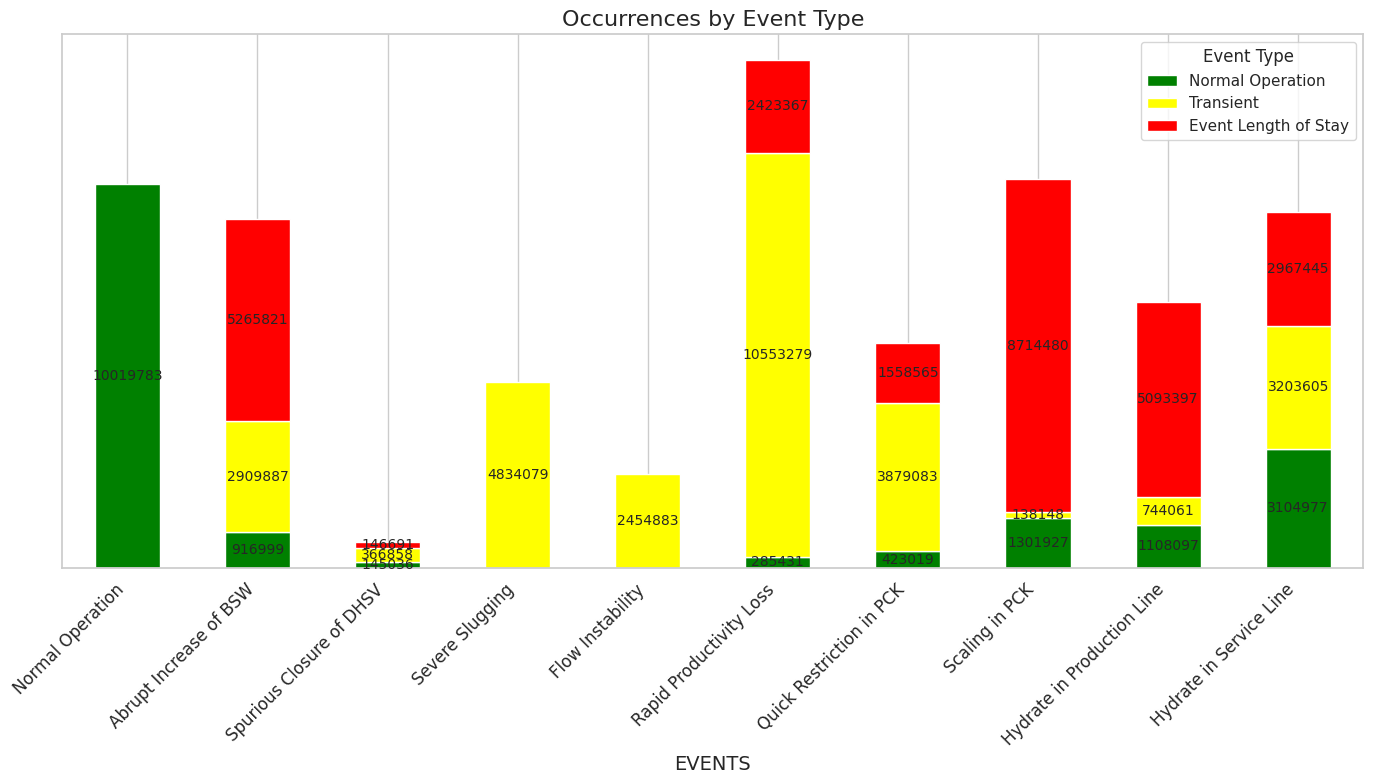

In [ ]:
# Definir os rótulos dos eventos
event_labels = {
    0: 'Normal Operation',
    1: 'Abrupt Increase of BSW',
    2: 'Spurious Closure of DHSV',
    3: 'Severe Slugging',
    4: 'Flow Instability',
    5: 'Rapid Productivity Loss',
    6: 'Quick Restriction in PCK',
    7: 'Scaling in PCK',
    8: 'Hydrate in Production Line',
    9: 'Hydrate in Service Line'
}

# Inicializar os dados para o gráfico, seguindo a estrutura dada
data = {
    'Normal Operation': [],
    'Transient': [],
    'Permanent Anomaly': []
}

# Verificar a distribuição da variável 'class' em todas as pastas e alimentar os dados
for i in range(10):
    if f'pasta_{i}' in dataframes:
        distribution = dataframes[f'pasta_{i}']['class'].value_counts().sort_index()

        # Capturar os valores para cada categoria
        normal_count = distribution.get(0, 0)  # Valores para 'Normal Operation'
        transient_count = distribution[(distribution.index >= 1) & (distribution.index <= 9)].sum()  # Valores de 1 a 9 (Transient)
        permanent_count = distribution[(distribution.index >= 101) & (distribution.index <= 109)].sum()  # Valores de 101 a 109 (Permanent Anomaly)

        # Adicionar os dados ao dicionário
        data['Normal Operation'].append(normal_count)
        data['Transient'].append(transient_count)
        data['Permanent Anomaly'].append(permanent_count)

# Criar um DataFrame com os dados para o gráfico
df_plot = pd.DataFrame(data, index=[event_labels[i] for i in range(10)])

# Configurar o gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar o gráfico empilhado com as três categorias
df_plot.plot(kind='bar', stacked=True, color=['green', 'yellow', 'red'], ax=ax)

# Ajustar o título e os rótulos dos eixos
ax.set_title('Occurrences by Event Type', fontsize=16)
ax.set_xlabel('EVENTS', fontsize=14)
ax.set_ylabel('AMOUNT', fontsize=14)
ax.set_xticks(range(len(event_labels)))
ax.set_xticklabels([event_labels[i] for i in range(10)], rotation=45, ha='right', fontsize=12)

# Eliminar a régua no eixo Y
ax.yaxis.set_visible(False)

# Ajustar a legenda
plt.legend(title='Event Type', labels=['Normal Operation', 'Transient', 'Event Length of Stay'], loc='upper right')

# Adicionar os números em cima de cada coluna e dentro das cores correspondentes
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        ax.text(p.get_x() + width/2, p.get_y() + height/2, f'{int(height)}', ha='center', va='center', fontsize=10)

# Ajustar os espaçamentos
plt.tight_layout()

# Exibir o gráfico
plt.show()


Com esse tipo de visualização, conseguimos escolher melhor um subconjunto de instâncias de eventos para trabalhar. Neste caso, finalizamos a Análise Exploratória inicial com os subconjuntos:

*   1 = Abrupt Increase of BSW
*   5 = Rapid Productivity Loss
*   9 = Hydrate in Service Line

Exibindo informações gerais do DataFrame (colunas, tipos de dados, entradas não nulas):

In [36]:
for i in [1, 5, 9]:
    print(f"\nInformações do DataFrame da pasta {i}:")
    print(dataframes[f'pasta_{i}'].info())



Informações do DataFrame da pasta 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9107107 entries, 0 to 9107106
Data columns (total 29 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ABER-CKGL      float64
 1   ABER-CKP       float64
 2   ESTADO-DHSV    float64
 3   ESTADO-M1      float64
 4   ESTADO-M2      float64
 5   ESTADO-PXO     float64
 6   ESTADO-SDV-GL  float64
 7   ESTADO-SDV-P   float64
 8   ESTADO-W1      float64
 9   ESTADO-W2      float64
 10  ESTADO-XO      float64
 11  P-ANULAR       float64
 12  P-JUS-BS       float64
 13  P-JUS-CKGL     float64
 14  P-JUS-CKP      float64
 15  P-MON-CKGL     float64
 16  P-MON-CKP      float64
 17  P-MON-SDV-P    float64
 18  P-PDG          float64
 19  PT-P           float64
 20  P-TPT          float64
 21  QBS            float64
 22  QGL            float64
 23  T-JUS-CKP      float64
 24  T-MON-CKP      float64
 25  T-PDG          float64
 26  T-TPT          float64
 27  class          Int16  
 28  stat

Também é importante avaliar alguns dados de Estatística descritiva das variáveis numéricas ( como média, desvio padrão, mínimo, máximo e quartis para todas as variáveis numéricas):

In [37]:
# Exibir estatísticas descritivas das variáveis numéricas nas pastas 1, 5 e 9
for i in [1, 5, 9]:
    print(f"\nEstatísticas descritivas das variáveis numéricas na pasta {i}:")
    print(dataframes[f'pasta_{i}'].describe())



Estatísticas descritivas das variáveis numéricas na pasta 1:
       ABER-CKGL  ABER-CKP    ESTADO-DHSV  ESTADO-M1  ESTADO-M2  ESTADO-PXO  \
count        0.0       0.0  218823.000000   218823.0   218823.0    218823.0   
mean         NaN       NaN       0.283645        1.0        0.0         0.0   
std          NaN       NaN       0.450768        0.0        0.0         0.0   
min          NaN       NaN       0.000000        1.0        0.0         0.0   
25%          NaN       NaN       0.000000        1.0        0.0         0.0   
50%          NaN       NaN       0.000000        1.0        0.0         0.0   
75%          NaN       NaN       1.000000        1.0        0.0         0.0   
max          NaN       NaN       1.000000        1.0        0.0         0.0   

       ESTADO-SDV-GL  ESTADO-SDV-P  ESTADO-W1  ESTADO-W2  ...  PT-P  \
count       218823.0      218823.0   218823.0   218823.0  ...   0.0   
mean             0.0           1.0        1.0        0.0  ...   NaN   
std          

Por fim, a contagem de valores nulos por coluna antecede o Pré-Processamento dos dados:

In [38]:
# Verificar a contagem de valores nulos por coluna nas pastas 1, 5 e 9
for i in [1, 5, 9]:
    print(f"\nContagem de valores nulos na pasta {i}:")
    print(dataframes[f'pasta_{i}'].isnull().sum())



Contagem de valores nulos na pasta 1:
ABER-CKGL        9107107
ABER-CKP         9107107
ESTADO-DHSV      8888284
ESTADO-M1        8888284
ESTADO-M2        8888284
ESTADO-PXO       8888284
ESTADO-SDV-GL    8888284
ESTADO-SDV-P     8888284
ESTADO-W1        8888284
ESTADO-W2        8888284
ESTADO-XO        8888284
P-ANULAR         8870313
P-JUS-BS         9107107
P-JUS-CKGL       8888284
P-JUS-CKP        9107107
P-MON-CKGL       9107107
P-MON-CKP          17971
P-MON-SDV-P      9107107
P-PDG                  0
PT-P             9107107
P-TPT                  0
QBS              9107107
QGL              8888284
T-JUS-CKP          17971
T-MON-CKP        9107107
T-PDG            8888284
T-TPT                  0
class              14400
state              14400
dtype: int64

Contagem de valores nulos na pasta 5:
ABER-CKGL        13241690
ABER-CKP         13241690
ESTADO-DHSV      12863403
ESTADO-M1        12863403
ESTADO-M2        12863403
ESTADO-PXO       12863403
ESTADO-SDV-GL    12863403
ES

À partir destes dados, vamos correlacionar e considerar as variáveis mais relevantes relacionadas à pressão, temperatura, fluxo e estado operacional do poço. </br></br>

Pressões:</br>
`P-ANULAR`: Pressure in the well annulus **[Pa]**</br>
`P-JUS-CKGL`: Downstream pressure of the GLCK (gas lift choke) **[Pa]**</br>
`P-JUS-CKP`: Downstream pressure of the PCK (production choke) **[Pa]**</br>
`P-MON-CKGL`: Upstream pressure of the GLCK (gas lift choke) **[Pa]**</br></br>
Temperaturas:</br>
`T-JUS-CKP`: Downstream temperature of the PCK (production choke) **[°C]**</br>
`T-MON-CKP`: Upstream temperature of the PCK (production choke) **[°C]**</br>
`T-PDG`: Temperature at the PDG (permanent downhole gauge) **[°C]**</br></br>
Fluxos:</br>
`QBS`: Flow rate at the SP (service pump) **[m³/s]**</br>
`QGL`: Gas lift flow rate **[m³/s]**</br></br>
Estado Operacional:</br>
`class`: Label of the observation (normal, transient, or permanent anomaly)</br>
`state` = Well operational status (open, closed)

**Tratamento Diferenciado de `state`:** A função plot_histogramas gera primeiro os histogramas das variáveis numéricas e, em seguida, um gráfico de barras separado para a variável state, mostrando a distribuição de estados operacionais.</br> **A cor verde indica o estado `"open" (aberto)` e vermelho indica `"closed" (fechado)`.**

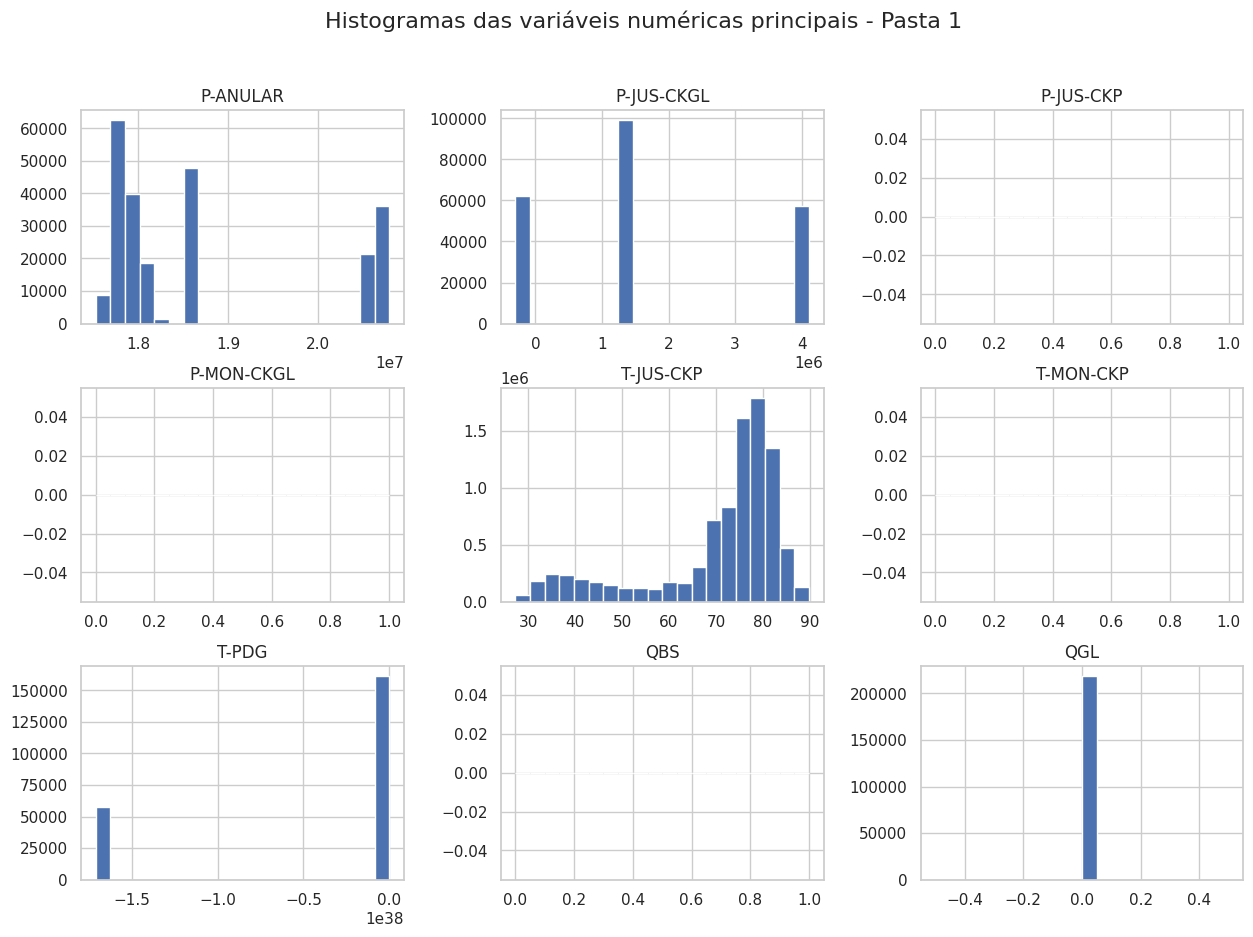

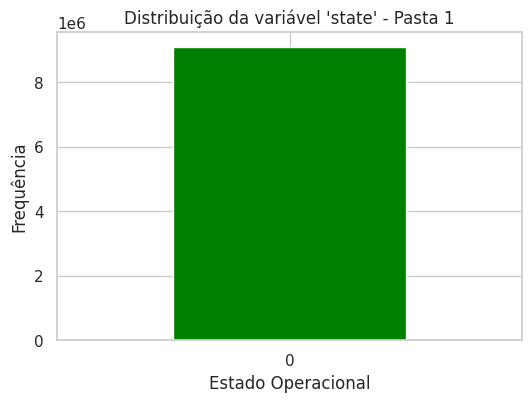

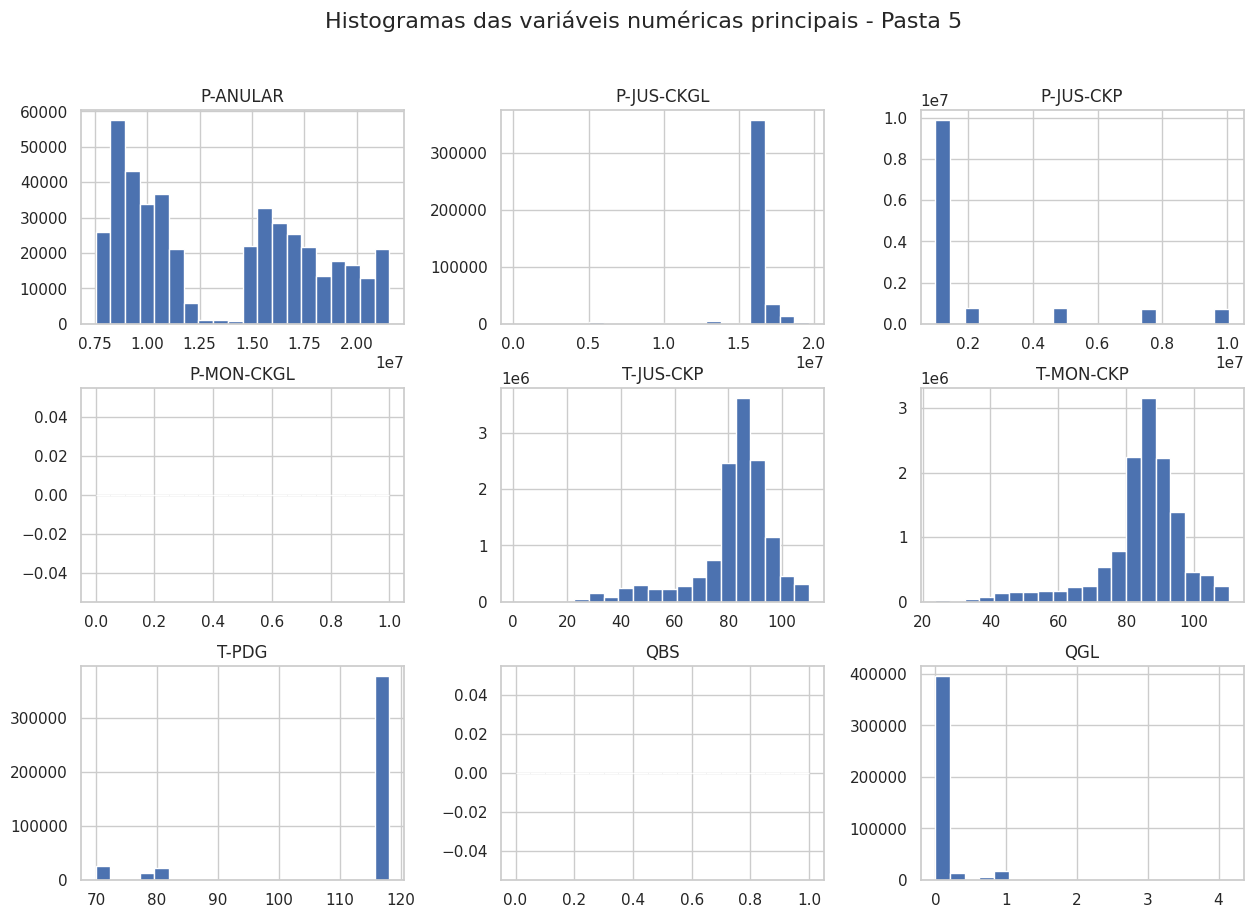

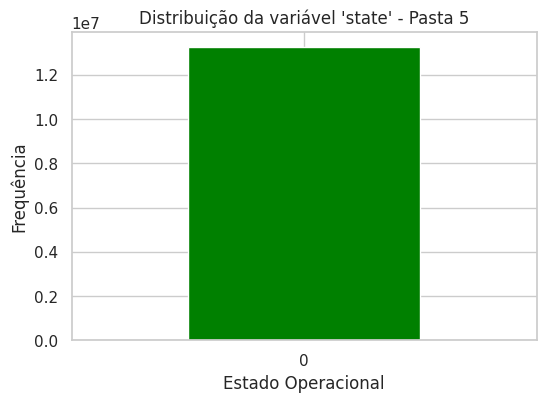

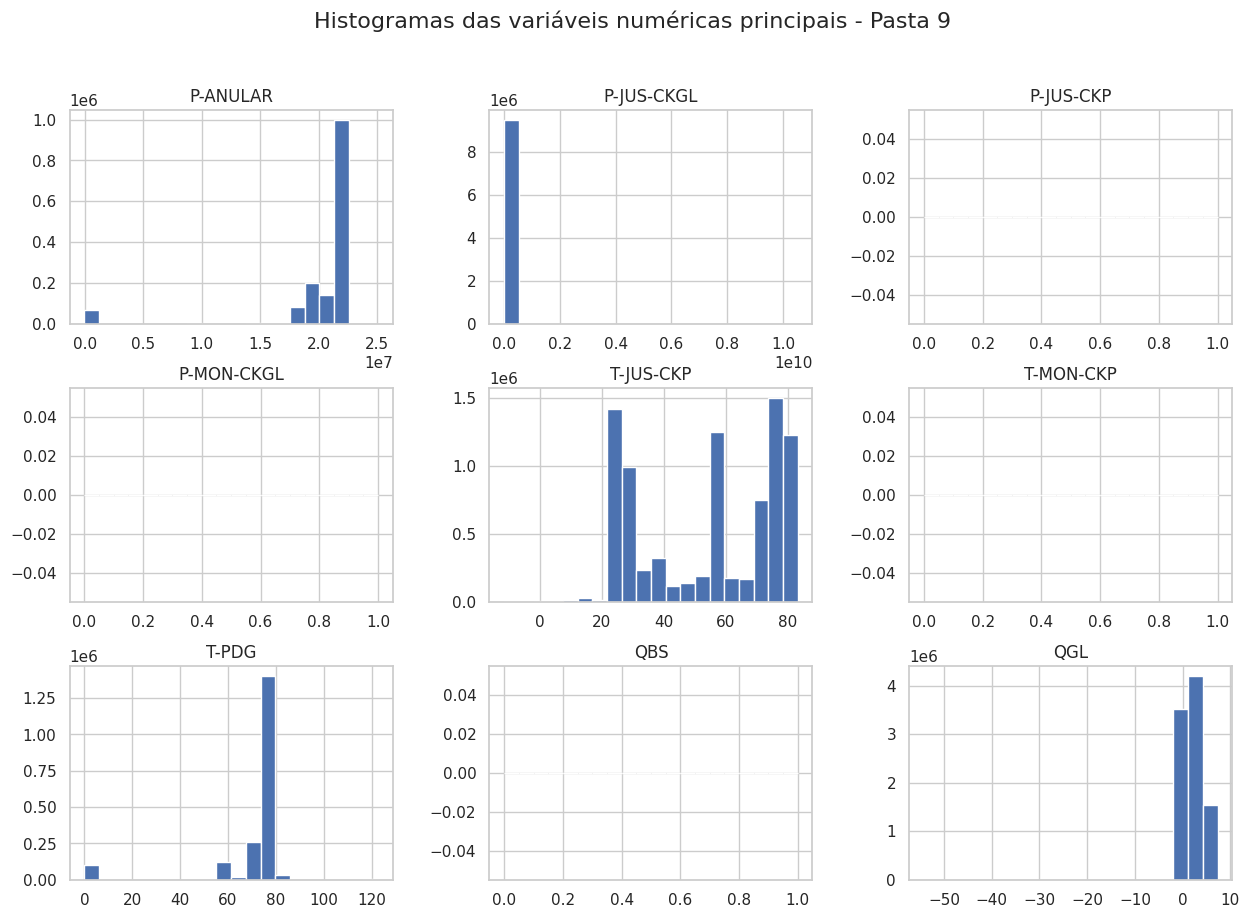

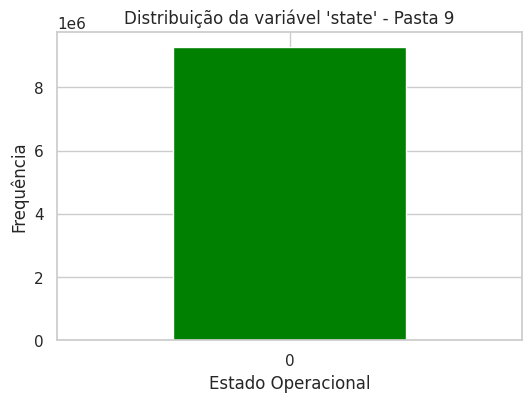

In [40]:
# Selecionar as variáveis principais para o histograma
variaveis_principais = [
    'P-ANULAR', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKGL',  # Pressões
    'T-JUS-CKP', 'T-MON-CKP', 'T-PDG',  # Temperaturas
    'QBS', 'QGL',  # Fluxos
    'class',  # Estado operacional (normal, transitório ou anomalia permanente)
    'state'  # Well operational status (open, closed)
]

# Função para plotar histogramas das variáveis principais
def plot_histogramas(df, pasta_num):
    # Selecionar apenas as variáveis principais que estão no DataFrame
    df_numeric = df[variaveis_principais].select_dtypes(include=['float64', 'int64'])

    # Gerar histogramas para as variáveis numéricas
    df_numeric.hist(bins=20, figsize=(15, 10))
    plt.suptitle(f"Histogramas das variáveis numéricas principais - Pasta {pasta_num}", fontsize=16)
    plt.show()

    # Plotar o histograma da variável categórica 'state' (estado operacional)
    plt.figure(figsize=(6, 4))
    df['state'].value_counts().plot(kind='bar', color=['green', 'red'])
    plt.title(f"Distribuição da variável 'state' - Pasta {pasta_num}")
    plt.xlabel('Estado Operacional')
    plt.ylabel('Frequência')
    plt.xticks(rotation=0)
    plt.show()

# Gerar histogramas das variáveis principais para as pastas 1, 5 e 9
for i in [1, 5, 9]:
    plot_histogramas(dataframes[f'pasta_{i}'], i)


## **1.4 Pré-processamento dos dados**

### **1.4.1  Normalização**

#### 1.4.1.1 Pipeline de Pré-processamento:

Remover variáveis congeladas `(remove_frozen_variables)`.

Preencher valores nulos `(ffill_nan ou replace_nan_with_values)`.

Normalizar os dados `(normalize)`.

In [86]:
from bibmon import PreProcess

# Definir a pipeline de pré-processamento
f_pp_train = ['remove_empty_variables', 'ffill_nan', 'remove_frozen_variables', 'normalize']
a_pp_train = {
    'normalize__mode': 'standard'  # Definir a normalização para modo padrão (z-score)
}

# Criar o objeto de pré-processamento
preprocessor = PreProcess(f_pp=f_pp_train, a_pp=a_pp_train)


#### **1.4.1.2 Aplicação do Pré-processamento:**

Vamos aplicar o código de pré-processamento aos dados de treino e teste, antes de seguir com as transformações.

In [87]:
# Aplicar o pré-processamento nos dados combinados de treino
df_processed = preprocessor.apply(df_combined, train_or_test='train')

# Exibir o DataFrame processado
print(df_processed.head())

   ABER-CKGL  ABER-CKP  ESTADO-M1  ESTADO-M2  ESTADO-PXO  ESTADO-SDV-GL  \
0  -0.965656 -1.383464   0.334053   0.198285   -0.008525        0.01304   
1  -0.965656 -1.383464   0.334053   0.198285   -0.008525        0.01304   
2  -0.965656 -1.383464   0.334053   0.198285   -0.008525        0.01304   
3  -0.965656 -1.383464   0.334053   0.198285   -0.008525        0.01304   
4  -0.965656 -1.383464   0.334053   0.198285   -0.008525        0.01304   

   ESTADO-W1  ESTADO-W2  ESTADO-XO  P-ANULAR  P-JUS-CKGL  P-MON-CKP     P-PDG  \
0    0.32469   0.041645  -0.027667 -0.057532   -0.056546  -0.232102 -0.489621   
1    0.32469   0.041645  -0.027667 -0.057532   -0.056546  -0.232102 -0.489621   
2    0.32469   0.041645  -0.027667 -0.057532   -0.056546  -0.232102 -0.489619   
3    0.32469   0.041645  -0.027667 -0.057532   -0.056546  -0.232101 -0.489619   
4    0.32469   0.041645  -0.027667 -0.057532   -0.056546  -0.232101 -0.489619   

      P-TPT       QGL  T-JUS-CKP     T-PDG     T-TPT     class

Converter os dados para formato numérico

In [90]:
# Função para converter colunas para formato numérico
def transformar_dados_para_numerico(df):
    return df.apply(pd.to_numeric, errors='coerce')

# Aplicar a função de conversão para todas as pastas e verificar os resultados
for i in range(10):
    pasta = f'pasta_{i}'

    if pasta in dataframes:
        print(f"\nTransformando dados para numérico na {pasta}...")

        # Verificar os tipos de colunas antes da conversão
        print(f"Tipos de colunas antes da conversão: \n{dataframes[pasta].dtypes}\n")

        # Aplicar a função de conversão
        dataframes[pasta] = transformar_dados_para_numerico(dataframes[pasta])

        # Verificar os tipos de colunas após a conversão
        print(f"Tipos de colunas após a conversão: \n{dataframes[pasta].dtypes}\n")

        # Contar valores NaN após a conversão
        print(f"Número de valores NaN após a conversão: \n{dataframes[pasta].isna().sum()}\n")

print("Transformação para numérico concluída!")



Transformando dados para numérico na pasta_0...
Tipos de colunas antes da conversão: 
ABER-CKGL        float64
ABER-CKP         float64
ESTADO-DHSV      float64
ESTADO-M1        float64
ESTADO-M2        float64
ESTADO-PXO       float64
ESTADO-SDV-GL    float64
ESTADO-SDV-P     float64
ESTADO-W1        float64
ESTADO-W2        float64
ESTADO-XO        float64
P-ANULAR         float64
P-JUS-CKGL       float64
P-JUS-CKP        float64
P-MON-CKP        float64
P-PDG            float64
P-TPT            float64
QGL              float64
T-JUS-CKP        float64
T-MON-CKP        float64
T-PDG            float64
T-TPT            float64
class            Float64
state            Float64
dtype: object

Tipos de colunas após a conversão: 
ABER-CKGL        float64
ABER-CKP         float64
ESTADO-DHSV      float64
ESTADO-M1        float64
ESTADO-M2        float64
ESTADO-PXO       float64
ESTADO-SDV-GL    float64
ESTADO-SDV-P     float64
ESTADO-W1        float64
ESTADO-W2        float64
ESTADO-XO   

#### 1.4.1.3 Verificação dos Dados Processados

Garantimos que os dados estejam consistentes após o pré-processamento.

In [92]:
# Função para verificar se há valores nulos após o pré-processamento, por coluna
def verificar_estrutura_dados_detalhada(df, pasta_num):
    nulos_totais = df.isnull().sum().sum()
    nulos_por_coluna = df.isnull().sum()
    total_colunas = len(df.columns)
    print(f"\nVerificação da estrutura da pasta {pasta_num}:")
    print(f"Total de valores nulos: {nulos_totais}")
    print(f"Total de colunas: {total_colunas}")

    # Exibir a contagem de valores nulos por coluna, se houver
    if nulos_totais > 0:
        print("\nValores nulos por coluna:")
        for coluna, nulos in nulos_por_coluna.items():
            if nulos > 0:
                print(f"{coluna}: {nulos} ({nulos/len(df)*100:.2f}%)")

# Verificar todas as pastas
for i in range(10):
    if f'pasta_{i}' in dataframes:
        verificar_estrutura_dados_detalhada(dataframes[f'pasta_{i}'], i)

print("Verificação detalhada da estrutura dos dados concluída!")



Verificação da estrutura da pasta 0:
Total de valores nulos: 12158183
Total de colunas: 24

Valores nulos por coluna:
ESTADO-PXO: 12158183 (100.00%)

Verificação da estrutura da pasta 1:
Total de valores nulos: 81963963
Total de colunas: 20

Valores nulos por coluna:
ESTADO-M1: 9107107 (100.00%)
ESTADO-M2: 9107107 (100.00%)
ESTADO-PXO: 9107107 (100.00%)
ESTADO-SDV-GL: 9107107 (100.00%)
ESTADO-SDV-P: 9107107 (100.00%)
ESTADO-W1: 9107107 (100.00%)
ESTADO-W2: 9107107 (100.00%)
ESTADO-XO: 9107107 (100.00%)
QGL: 9107107 (100.00%)

Verificação da estrutura da pasta 2:
Total de valores nulos: 2213355
Total de colunas: 21

Valores nulos por coluna:
ESTADO-M1: 737785 (100.00%)
ESTADO-XO: 737785 (100.00%)
QGL: 737785 (100.00%)

Verificação da estrutura da pasta 3:
Total de valores nulos: 34644953
Total de colunas: 22

Valores nulos por coluna:
ESTADO-DHSV: 4949279 (100.00%)
ESTADO-M1: 4949279 (100.00%)
ESTADO-M2: 4949279 (100.00%)
ESTADO-PXO: 4949279 (100.00%)
ESTADO-SDV-P: 4949279 (100.00%)
ES

Colunas com 100% de valores nulos, como `ESTADO-M1`, `ESTADO-M2`, `ESTADO-PXO`, entre outras, estão presentes em várias pastas.

Essas colunas não carregam nenhuma informação útil para o modelo, e, portanto, podem ser removidas com segurança.

#### 1.4.1.4 Tratamento de Valores Nulos

Para colunas que não possuem 100% de valores nulos, adotamos as seguintes estratégias de preenchimento de valores nulos:

* **Preenchimento com o Valor Anterior `(ffill)`:** Boa opção para colunas que representam variáveis contínuas e em séries temporais, como pressões, temperaturas e fluxos. Esse método assume que a operação anterior continua até que uma nova observação seja registrada.

* **Preenchimento com o Valor Seguinte `(bfill)`:** Alternativa ao `ffill`, útil quando os valores iniciais estão ausentes.

* **Preenchimento com a Mediana/Média:** Para variáveis como temperatura, fluxo e pressão, o preenchimento pela mediana seria mais adequado devido à possibilidade de outliers.

* **Remover as Colunas ou Linhas:** Para colunas que têm uma quantidade considerável de valores nulos **(por exemplo, acima de 80%)**, mas não chegam a 100%, também pode ser interessante remover essas colunas ou linhas, se não forem consideradas essenciais para a análise.

In [93]:
# Função para remover colunas com 100% de valores nulos e preencher outros valores nulos
def tratar_valores_nulos(df, strategy='ffill'):
    # Remover colunas com 100% de valores nulos
    colunas_completamente_nulas = df.columns[df.isnull().mean() == 1]
    df = df.drop(colunas_completamente_nulas, axis=1)

    # Preenchimento de valores nulos restantes
    if strategy == 'ffill':
        df = df.fillna(method='ffill')
    elif strategy == 'bfill':
        df = df.fillna(method='bfill')
    elif strategy == 'median':
        df = df.fillna(df.median())
    elif strategy == 'mean':
        df = df.fillna(df.mean())

    return df

# Aplicar a função de tratamento de valores nulos para todas as pastas
for i in range(10):
    if f'pasta_{i}' in dataframes:
        dataframes[f'pasta_{i}'] = tratar_valores_nulos(dataframes[f'pasta_{i}'], strategy='ffill')

print("Tratamento de valores nulos concluído!")


<ipython-input-93-a526737acde5>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Tratamento de valores nulos concluído!


#### **1.4.1.5 Validação da Estrutura dos Dados Após o Preenchimento**

In [94]:
# Repetir a verificação para garantir que não há mais valores nulos
for i in range(10):
    if f'pasta_{i}' in dataframes:
        verificar_estrutura_dados_detalhada(dataframes[f'pasta_{i}'], i)

print("Verificação pós-tratamento dos valores nulos concluída!")



Verificação da estrutura da pasta 0:
Total de valores nulos: 0
Total de colunas: 23

Verificação da estrutura da pasta 1:
Total de valores nulos: 0
Total de colunas: 11

Verificação da estrutura da pasta 2:
Total de valores nulos: 0
Total de colunas: 18

Verificação da estrutura da pasta 3:
Total de valores nulos: 0
Total de colunas: 15

Verificação da estrutura da pasta 4:
Total de valores nulos: 0
Total de colunas: 18

Verificação da estrutura da pasta 5:
Total de valores nulos: 0
Total de colunas: 18

Verificação da estrutura da pasta 6:
Total de valores nulos: 0
Total de colunas: 11

Verificação da estrutura da pasta 7:
Total de valores nulos: 0
Total de colunas: 15

Verificação da estrutura da pasta 8:
Total de valores nulos: 0
Total de colunas: 25

Verificação da estrutura da pasta 9:
Total de valores nulos: 0
Total de colunas: 20
Verificação pós-tratamento dos valores nulos concluída!


### **1.4.2 Identificação de Ruídos e Outliers**

No contexto do dataset **3W**, podemos identificar valores que estão fora de uma faixa esperada de operação, como pressões ou temperaturas muito altas ou muito baixas.

#### **1.4.2.1 Método IQR (Interquartile Range)**

- Podemos usar o método do **IQR** para detectar outliers. Um valor será considerado um outlier se estiver:

  - abaixo de $$Q1 - 1.5 \times IQR$$
  - ou acima de $$Q3 + 1.5 \times IQR$$

Aqui está o código para identificar os outliers em variáveis-chave **(pressão, temperatura, fluxo)** nos datasets das pastas 1, 5 e 9:


Outliers detectados na instância 1 = Abrupt Increase of BSW:


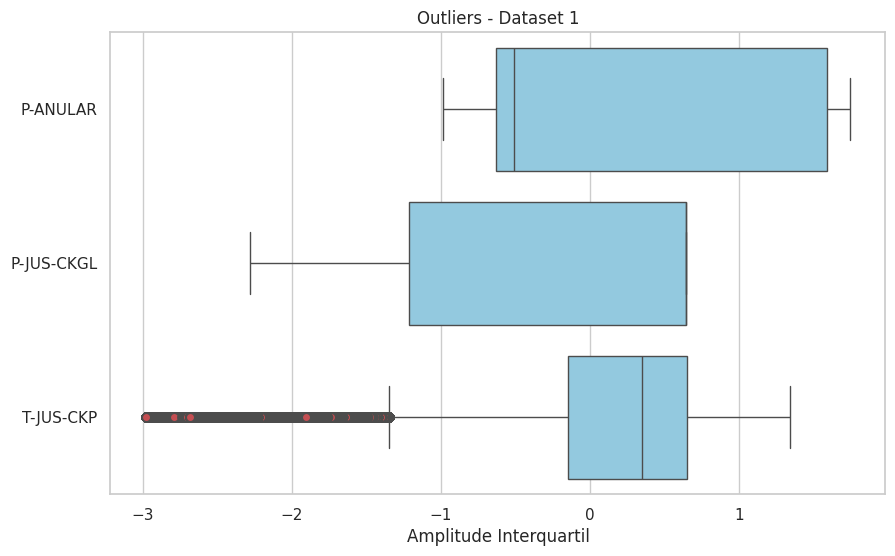

Outliers detectados na instância pasta 5 = Rapid Productivity Loss:


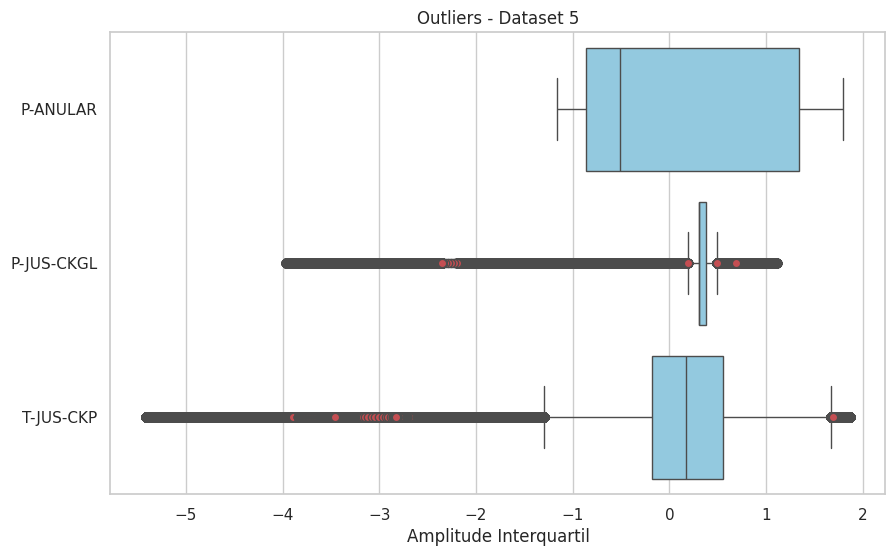

Outliers detectados na instância pasta 9 = Hydrate in Service Line:


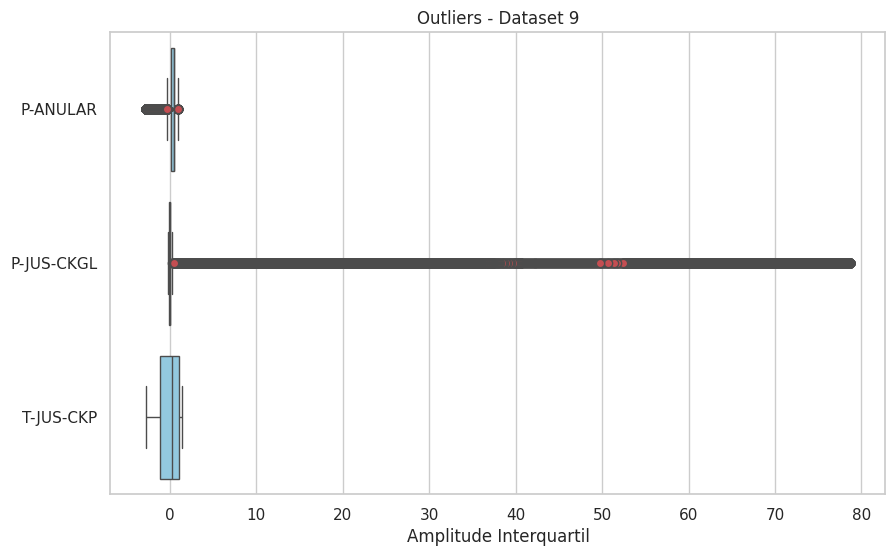

In [99]:
# Função para detectar outliers usando IQR (Amplitude Interquartil)
def detectar_outliers_corrigido(df, colunas):
    outliers = {}
    for coluna in colunas:
        if coluna in df.columns:
            Q1 = df[coluna].quantile(0.25)
            Q3 = df[coluna].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            # Verificar se há valores preenchidos anteriormente com a mediana/média
            if df[coluna].isnull().sum() == 0:
                # Detectar os outliers
                outliers[coluna] = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
            else:
                print(f"Coluna {coluna} foi preenchida, verificar adequação dos dados.")

    return outliers

# Colunas principais para verificar outliers (pressão, temperatura e fluxo)
variaveis_principais = ['P-ANULAR', 'P-JUS-CKGL', 'T-JUS-CKP']

# Aplicar a função corrigida de detecção de outliers nas pastas 1, 5 e 9
outliers_pasta_1 = detectar_outliers_corrigido(dataframes['pasta_1'], variaveis_principais)
outliers_pasta_5 = detectar_outliers_corrigido(dataframes['pasta_5'], variaveis_principais)
outliers_pasta_9 = detectar_outliers_corrigido(dataframes['pasta_9'], variaveis_principais)

# Função para plotar boxplots com os outliers detectados
def plotar_boxplots_outliers(df, pasta_num, variaveis_principais):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[variaveis_principais], orient="h", color="skyblue", flierprops=dict(markerfacecolor='r', marker='o'))
    plt.title(f"Outliers - Dataset {pasta_num}")
    plt.xlabel("Amplitude Interquartil")
    plt.show()

# Plotar boxplots para as pastas
print("Outliers detectados na instância 1 = Abrupt Increase of BSW:")
plotar_boxplots_outliers(dataframes['pasta_1'], 1, variaveis_principais)

print("Outliers detectados na instância pasta 5 = Rapid Productivity Loss:")
plotar_boxplots_outliers(dataframes['pasta_5'], 5, variaveis_principais)

print("Outliers detectados na instância pasta 9 = Hydrate in Service Line:")
plotar_boxplots_outliers(dataframes['pasta_9'], 9, variaveis_principais)

Os outliers representados em vermelho nos gráficos mostram variações extremas que podem estar relacionadas a eventos anômalos nos processos monitorados.


*   **Dataset 1 = Abrupt Increase of BSW:** Há poucos outliers identificados, principalmente na variável `T-JUS-CKP`, que indica variações consideráveis na temperatura a jusante do estrangulador de produção. Esses outliers podem sugerir flutuações no controle de temperatura durante o evento de aumento abrupto de BSW.

*   **Dataset 5 = Rapid Productivity Loss:** As variáveis `P-JUS-CKGL` (pressão a jusante do estrangulador de gás de elevação) e `T-JUS-CKP` mostram um número considerável de outliers, sugerindo flutuações tanto de pressão quanto de temperatura durante o evento de perda rápida de produtividade. Esses comportamentos anômalos são esperados, pois o sistema pode passar por instabilidades significativas.

*   **Dataset 9 = Hydrate in Service Line:** A variável `P-JUS-CKGL` apresenta uma grande concentração de outliers, indicando possíveis flutuações de pressão significativas. Isso é coerente com a formação de hidratos na linha de serviço, que pode afetar o fluxo e a pressão no sistema.




## **1.5 Proposta de criação de duas novas funções no PreProcess da BibMon**

Uma ideia interessante para aprimorar o módulo PreProcess da BibMon seria adicionar uma função que detecta e lida com outliers automaticamente. Atualmente, o BibMon lida com variáveis congeladas e valores nulos, mas o tratamento de outliers pode ser um complemento importante.

**Proposta de 2 novas funções:** `detect_outliers_iqr` e `remove_outliers` </br>
`detect_outliers_iqr`será integrada ao módulo de pré-processamento, permitindo que os usuários apliquem a detecção de outliers automaticamente ao carregar os dados.</br>
E `remove_outliers` poderia ser integrada ao pipeline de pré-processamento e remover ou substituir outliers com base no método **IQR**.

### **1.5.1 Função `detect_outliers_iqr`**

In [71]:
class PreProcess:
    def __init__(self, f_pp=None, a_pp=None, is_Y=False):
        self.f_pp = f_pp if f_pp else []
        self.a_pp = a_pp if a_pp else {}
        self.is_Y = is_Y

    def detect_outliers_iqr(self, df, cols):
        """
        Detecta outliers usando a técnica da Amplitude Interquartil (IQR).
        Outliers serão valores fora da faixa [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

        Parâmetros:
        df (DataFrame): DataFrame contendo os dados para analisar.
        cols (list): Lista de colunas numéricas para detectar outliers.

        Retorna:
        DataFrame: DataFrame atualizado com os outliers removidos ou sinalizados.
        """
        for col in cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            # Marcar os outliers com base no IQR
            df[f'{col}_outlier'] = ((df[col] < limite_inferior) | (df[col] > limite_superior)).astype(int)

            # Opcional: Remover outliers
            # df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]

        return df


**Exemplo de Uso no Notebook:**

A seguir, implementamos e aplicamos a função para os datasets das pastas 1, 5 e 9, incluindo as variáveis mais relevantes. **(AINDA NÃO IMPLEMENTADO NA PreProcess).**

In [72]:
# Importar o PreProcess com a nova função de detecção de outliers
from bibmon import PreProcess #(essa etapa não vai funcionar porque o pull request não foi feito)

# Colunas principais para verificar outliers
variaveis_principais = ['P-ANULAR', 'P-JUS-CKGL', 'T-JUS-CKP', 'QGL']

# Instanciar o PreProcess e aplicar a função detect_outliers_iqr
preprocessor = PreProcess()

# Aplicar a detecção de outliers no dataset da pasta 1
df_pasta_1_outliers = preprocessor.detect_outliers_iqr(dataframes['pasta_1'], variaveis_principais)

# Aplicar a detecção de outliers no dataset da pasta 5
df_pasta_5_outliers = preprocessor.detect_outliers_iqr(dataframes['pasta_5'], variaveis_principais)

# Aplicar a detecção de outliers no dataset da pasta 9
df_pasta_9_outliers = preprocessor.detect_outliers_iqr(dataframes['pasta_9'], variaveis_principais)

# Exibir amostra dos resultados com os outliers marcados
print(df_pasta_1_outliers[['P-ANULAR', 'P-ANULAR_outlier']].head())


AttributeError: 'PreProcess' object has no attribute 'detect_outliers_iqr'

**Resultados Esperados:** </br>
A aplicação dessa função irá adicionar colunas extras ao DataFrame que indicam se o valor é um outlier `(1)` ou não `(0)`. Isso facilita a análise dos dados e permite que os outliers sejam tratados de maneira automática durante o pré-processamento.

**Teste Adicional:** </br>
Podemos adicionar um teste unitário no BibMon para garantir que a função de detecção de outliers funcione conforme o esperado em diferentes cenários. Isso é importante para garantir a robustez da funcionalidade antes de submeter a pull request.

In [73]:
def test_detect_outliers_iqr():
    df_teste = pd.DataFrame({
        'col1': [10, 12, 14, 1000],  # Inclui um outlier
        'col2': [1, 2, 3, 4]
    })

    preprocessor = PreProcess()
    df_result = preprocessor.detect_outliers_iqr(df_teste, ['col1'])

    # Verificar se o outlier foi corretamente identificado
    assert df_result['col1_outlier'].iloc[-1] == 1  # Outlier
    assert df_result['col1_outlier'].iloc[0] == 0  # Não é outlier


### **1.5.2 Função `remove_outliers`:**

**(AINDA NÃO IMPLEMENTADA NA PreProcess)**

In [100]:
class PreProcess:

    # Adicionando a função de remoção de outliers ao PreProcess (não foi enviado Pull Request)
    def remove_outliers(self, df, cols=None, method='IQR'):
        """Remove or replaces outliers using the specified method.

        Parameters:
        df (pd.DataFrame): DataFrame com os dados a serem processados.
        cols (list): Colunas onde os outliers serão verificados.
        method (str): Método para detecção de outliers ('IQR' ou outro).

        Returns:
        pd.DataFrame: DataFrame com outliers tratados.
        """
        if cols is None:
            cols = df.columns

        for col in cols:
            if method == 'IQR':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                limite_inferior = Q1 - 1.5 * IQR
                limite_superior = Q3 + 1.5 * IQR

                # Substituir outliers com NaN para que possam ser preenchidos
                df[col] = np.where((df[col] < limite_inferior) | (df[col] > limite_superior), np.nan, df[col])

        return df

# Exemplo de uso da função
preprocessor = PreProcess(f_pp=['remove_outliers'])
df_processed = preprocessor.remove_outliers(dataframes['pasta_1'], cols=variaveis_principais)

print("Pré-processamento com remoção de outliers concluído!")


TypeError: PreProcess() takes no arguments

Possíveis Ajustes e Melhorias:
* **Tratamento de Outliers:** A função pode remover, substituir ou ajustar os outliers de acordo com diferentes estratégias (substituir por média, mediana, etc.).
* **Personalização:** Permitiria o ajuste do método de detecção (como o uso de z-score em vez de IQR).
* **Validação:** Verificações automáticas para garantir que a remoção dos outliers não afete negativamente a estrutura dos dados.

#   **2. Aplicação das Técnicas de Inteligência Artificial da BibMon para Detecção dos Diferentes Eventos Indesejados no 3W Dataset**

Nesta seção, vamos aplicar técnicas de inteligência artificial da biblioteca BibMon para detectar os diferentes eventos indesejados presentes no 3W Dataset. Focaremos na aplicação do modelo PCA para detecção de anomalias.

## **2.1 Pré-processamento dos Dados**

É importante remover colunas que não são relevantes para a análise, como colunas que indicam classes ou estados, que não devem ser utilizadas como variáveis preditoras no modelo PCA.

In [170]:
# Armazenar a coluna 'class' antes de removê-la
if 'class' in df_processed.columns:
    df_labels = df_processed['class'].copy()
    df_features = df_processed.drop(columns=['class'])
else:
    raise ValueError("A coluna 'class' não foi encontrada no DataFrame.")

In [171]:
# Remover a coluna 'class' dos conjuntos de treinamento e teste
df_train_pca = df_train.drop(columns=['class'])
df_test_pca = df_test.drop(columns=['class'])

## **2.2 Divisão dos Dados em Treino e Teste:**

Dividiremos o conjunto de dados pré-processado em conjuntos de treinamento e teste. Usaremos 80% dos dados para treinamento e 20% para teste.

In [169]:
# Separar as features e as labels
df_features = df_processed.drop(columns=['class'])
df_labels = df_processed['class'].copy()

In [162]:
# Dividir os dados e as labels em conjuntos de treinamento e teste
df_train_pca, df_test_pca, df_labels_train, df_labels_test = train_test_split(
    df_features, df_labels, test_size=0.2, random_state=42)

# Verificar as dimensões dos conjuntos
print("\nDimensões do conjunto de treinamento:", df_train_pca.shape)
print("Dimensões do conjunto de teste:", df_test_pca.shape)


Dimensões do conjunto de treinamento: (7584981, 18)
Dimensões do conjunto de teste: (1896246, 18)


## 2.3 Treinamento do Modelo PCA da BibMon
Inicializar o modelo PCA da BibMon e treiná-lo com os dados de treinamento.


Número de componentes principais utilizados: 12


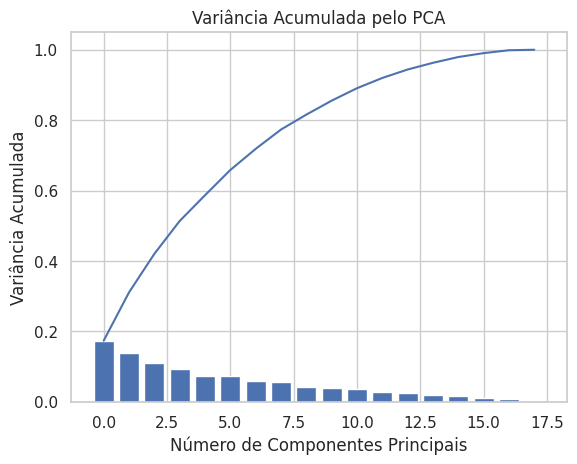

In [141]:
# Inicializar o modelo PCA da BibMon
model = bibmon.PCA(ncomp=0.9)

# Treinar o modelo PCA com os dados de treinamento limpos
model.fit(X_train=df_train_pca)

# Após o treinamento, podemos verificar os componentes principais
print("\nNúmero de componentes principais utilizados:", model.n)

# Plotar a variância acumulada
fig, ax = plt.subplots()
model.plot_cumulative_variance(ax=ax)
plt.title("Variância Acumulada pelo PCA")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Acumulada")
plt.show()


## **2.4 Aplicação do Modelo aos Dados de Teste**

Após o treinamento, aplicaremos o modelo PCA aos dados de teste para detectar possíveis anomalias.

In [172]:
# Aplicar o modelo aos dados de teste
model.predict(X_test=df_test_pca)

# Acessar o SPE (Squared Prediction Error) do conjunto de teste
SPE_test = model.SPE_test
print("SPE do conjunto de teste:")
print(SPE_test)

# Acessar os alarmes de outlier
alarm_outlier = model.alarmOutlier
print("Alarmes de outlier no conjunto de teste:")
print(alarm_outlier)


SPE do conjunto de teste:
8007830    1.004514
3102826    0.841009
7673853    1.153714
1957591    3.683456
2117977    4.433774
             ...   
2859117    1.028667
765359     0.504371
3571319    0.510735
1966311    3.768411
4094341    0.407661
Length: 1896246, dtype: float64
Alarmes de outlier no conjunto de teste:
8007830    0.0
3102826    0.0
7673853    0.0
1957591    0.0
2117977    0.0
          ... 
2859117    0.0
765359     0.0
3571319    0.0
1966311    0.0
4094341    0.0
Length: 1896246, dtype: float64


## **2.5 Visualização dos Resultados**


### **2.5.1 Plotagem do SPE**

Plotamos o SPE ao longo do tempo para visualizar onde o modelo detecta anomalias.


SPE do conjunto de teste:
8007830    1.004514
3102826    0.841009
7673853    1.153714
1957591    3.683456
2117977    4.433774
             ...   
2859117    1.028667
765359     0.504371
3571319    0.510735
1966311    3.768411
4094341    0.407661
Length: 1896246, dtype: float64

Alarmes de outlier no conjunto de teste:
8007830    0.0
3102826    0.0
7673853    0.0
1957591    0.0
2117977    0.0
          ... 
2859117    0.0
765359     0.0
3571319    0.0
1966311    0.0
4094341    0.0
Length: 1896246, dtype: float64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


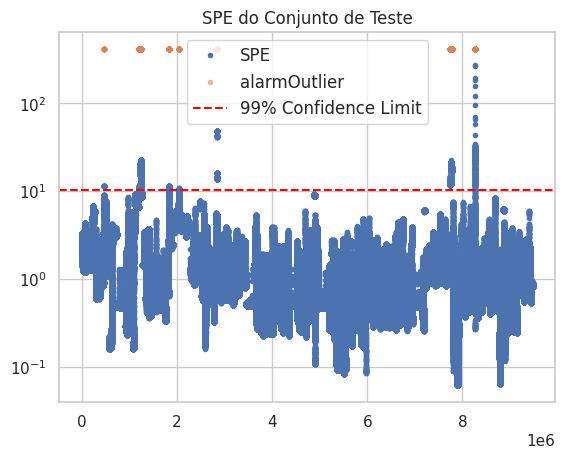

In [135]:
# Acessar o SPE do conjunto de teste
SPE_test = model.SPE_test
print("\nSPE do conjunto de teste:")
print(SPE_test)

# Acessar alarmes de outlier
alarm_outlier = model.alarmOutlier
print("\nAlarmes de outlier no conjunto de teste:")
print(alarm_outlier)

# Plotar o SPE
fig, ax = plt.subplots()
model.plot_SPE(ax=ax, train_or_test='test', logy=True)
plt.title("SPE do Conjunto de Teste")
plt.show()

# **3. Avaliação da efetividade das técnicas aplicadas**

Nesta seção, avaliaremos a efetividade do modelo PCA aplicado, utilizando métricas como taxa de detecção de falhas (FDR) e taxa de falsos alarmes.

## **3.1 Cálculo da Taxa de Detecção de Falhas (FDR**)

**`FDR` (Taxa de Detecção de Falhas)**: Indica a capacidade do modelo em detectar corretamente as falhas presentes no conjunto de teste. Um valor alto é desejável.

In [176]:
# Reconstruir o DataFrame de teste com as labels
df_test_with_labels = df_test_pca.copy()
df_test_with_labels['class'] = df_labels_test.values

# Definir um array booleano indicando onde há falhas no conjunto de teste
is_fault = df_test_with_labels['class'].values != 0

# Obter os alarmes gerados pelo modelo
alarms = model.alarmOutlier.astype(bool)

# Calcular Verdadeiros Positivos (TP) e Falsos Negativos (FN)
true_positives = np.sum(alarms & is_fault)
false_negatives = np.sum(~alarms & is_fault)

# Calcular a Taxa de Detecção de Falhas (FDR)
if (true_positives + false_negatives) > 0:
    FDR = true_positives / (true_positives + false_negatives) * 100
else:
    FDR = 0
print(f"Taxa de Detecção de Falhas (FDR): O modelo detectou {FDR:.2f}% das falhas existentes.")

Taxa de Detecção de Falhas (FDR): O modelo detectou 1.01% das falhas existentes.


## 3.2 Cálculo da Taxa de Falsos Alarmes

**`FAR` (Taxa de Falsos Alarmes)**: Indica a frequência com que o modelo gera alarmes falsos durante a operação normal. Um valor baixo é desejável.

In [177]:
# Calcular a Taxa de Falsos Alarmes (FAR)
if (false_positives + true_negatives) > 0:
    FAR = false_positives / (false_positives + true_negatives) * 100
else:
    FAR = 0
print(f"Taxa de Falsos Alarmes (FAR): {FAR:.2f}%")

Taxa de Falsos Alarmes (FAR): 0.00%


Nenhum alarme falso foi gerado, indicando que todas as detecções de anomalias eram corretas ou que não houve alarmes falsos.

Agora que calculamos as taxas, vamos avaliar a efetividade do modelo.

Interpretação:

> Se o FDR for alto e o FAR for baixo, o modelo **é eficaz na detecção de falhas com poucos falsos alarmes.**

> Se o `FDR` for baixo, o modelo está **perdendo falhas que deveriam ser detectadas**.

> Se o `FAR` for alto, o modelo está **gerando muitos alarmes falsos, o que pode levar a alarmes desnecessários.**



## **3.3 Análise dos Resultados**

#### 3.3.1 **Taxa de Detecção de Falhas (FDR)**

O FDR obtido foi de `1.01%`, o que indica que o modelo conseguiu detectar aproximadamente 1% das falhas existentes no conjunto de teste. Este valor é consideravelmente baixo, sugerindo que **o modelo possui uma capacidade limitada de identificar corretamente as anomalias presentes nos dados**. Isso pode ser atribuído a diversos fatores, tais como a **complexidade dos eventos de falha, a configuração atual dos hiperparâmetros do modelo, ou possíveis limitações na representatividade dos dados de treinamento.**

### 3.3.2 Taxa de Falsos Alarmes (FAR)

Por outro lado, o FAR foi calculado como `0.00%`, indicando que o modelo não gerou nenhum alarme falso durante a análise. Embora este valor seja desejável em termos de evitar alarmes desnecessários, **a ausência completa de falsos alarmes pode também sugerir que o modelo está sendo excessivamente conservador, não conseguindo identificar nem mesmo as falhas reais com alta frequência.**

### **3.3.3 Interpretação dos Resultados**

A combinação de um `FDR` baixo e um `FAR` muito baixo sugere que o modelo PCA atual está enfrentando um **trade-off** desfavorável entre sensibilidade e especificidade.

Enquanto minimiza a ocorrência de alarmes falsos, compromete significativamente a capacidade de detecção de falhas. Este cenário aponta para a **necessidade de ajustes finos no modelo e no pré-processamento dos dados para melhorar o equilíbrio entre essas métricas.**

## **3.4 Ajustes e Melhorias**

#### **3.4.1 Ajustar o Limite de Confiança `(lim_conf)`:**

Segundo a documentação, o método `fit` da classe `bibmon.PCA` aceita `lim_conf` como um parâmetro de entrada, utilizado para controlar o nível de confiança para o limite de detecção. Reduzir o valor pode aumentar a sensibilidade do modelo, mas também pode aumentar os falsos alarmes.



```
fit(X_train, Y_train=None, ..., lim_conf=0.99, ...)
```



#### **3.4.2 Balanceamento de Dados:**

Aplicar técnicas de ***oversampling*** ou ***undersampling*** para tratar o desequilíbrio de classes, garantindo que o modelo tenha dados suficientes para aprender a identificar falhas.

#### **3.4.3 Validação Cruzada:**

Implementar métodos de validação cruzada para uma avaliação mais robusta do modelo, reduzindo a variabilidade nos resultados.

#### **3.4.4 Tradução para o Inglês**

A tradução de todo o conteúdo do notebook para o inglês ampliará o alcance e a acessibilidade do trabalho, permitindo que uma audiência mais ampla possa compreender e replicar os resultados.

#### **3.4.5 Citações e Referências com Links**

Documentação e Papers: Incorporar citações diretas para a documentação oficial da biblioteca BibMon e para os papers referenciados, utilizando links diretos para facilitar o acesso dos leitores.

#### **3.4.6 Pull Requests para Funções Sugeridas**

**Implementação das Novas Funções:** Desenvolver e integrar as funções detect_outliers_iqr e remove_outliers no módulo PreProcess da biblioteca BibMon.

**Testes Unitários:** Adicionar testes unitários para as novas funções, garantindo sua robustez e correto funcionamento em diferentes cenários.

> Submissão de Pull Requests: Após a implementação e testes, submeter pull requests para o repositório oficial da biblioteca BibMon, propondo as novas funcionalidades para revisão e possível inclusão na versão principal.



#### **3.4.7 Melhoria na Visualização e Documentação**

**Visualizações Interativas:** Incorporar gráficos interativos utilizando bibliotecas como `Plotly` ou `Bokeh` para uma análise mais dinâmica dos dados e resultados.

**Documentação Detalhada:** Expandir as seções de documentação no notebook, fornecendo descrições mais detalhadas das etapas e justificativas para as escolhas metodológicas.

#### **3.4.8 Automação do Pipeline de Pré-processamento**

**Scripts Automatizados:** Desenvolver scripts que automatizem as etapas de pré-processamento, garantindo consistência e eficiência na preparação dos dados para diferentes modelos.